In [32]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, MACCSkeys
from sklearn.preprocessing import StandardScaler
import numpy as np
from rdkit.Chem import rdmolops
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns 
import matplotlib.pyplot as plt
import os

In [33]:
tox21 = pd.read_csv('data/tox21.csv')
smiles_list = tox21['SMILES'].tolist()
label_columns = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']
targets = tox21[label_columns]


In [34]:
# Functions for Feature Extraction
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {
        "MolecularWeight": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "TPSA": Descriptors.TPSA(mol),
    }
    return descriptors

def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    return {
        "MorganFP": list(morgan_fp),
        "MACCSFP": list(maccs_fp),
    }

def compute_graph_features(graph):
    features = {
        "AverageDegree": sum(dict(graph.degree()).values()) / len(graph.nodes()),
        "Density": nx.density(graph),
        "ClusteringCoefficient": nx.average_clustering(graph),
    }
    if nx.is_connected(graph):
        features["Diameter"] = nx.diameter(graph)
    else:
        features["Diameter"] = None
    return features

def compute_node2vec_embeddings(graph, dimensions=64):
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=30, num_walks=50, workers=12, seed=42)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    node_embeddings = np.array([model.wv[str(node)] for node in graph.nodes()])
    graph_embedding = node_embeddings.mean(axis=0)  
    return graph_embedding

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol)
    graph = nx.from_numpy_array(adjacency_matrix)
    for i, atom in enumerate(mol.GetAtoms()):
        graph.nodes[i]['atom_type'] = atom.GetSymbol()
    return graph

In [35]:
if not os.path.exists('data/features.csv'):
    features = []
    for smile in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smile)
            graph = smiles_to_graph(smile)
            
            descriptors = compute_descriptors(smile)
            fingerprints = compute_fingerprints(smile)
            graph_features = compute_graph_features(graph)
            node2vec_embeddings = compute_node2vec_embeddings(graph)
            
            combined_features = {**descriptors, **fingerprints, **graph_features, **{f"Node2Vec{i}": node2vec_embeddings[i] for i in range(len(node2vec_embeddings))}}
            features.append(combined_features)
        except Exception as e:
            print(f"Tus muertos pisados {smile}: {e}")
        clear_output(wait=True)

    feature_df = pd.DataFrame(features)
    feature_df.to_csv('data/features.csv', index=False)
else:
    feature_df = pd.read_csv('data/features.csv')


In [36]:
#feature_df.drop(
#    ['MorganFP', 'MACCSFP'], axis=1, inplace=True
#)


In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

morgan = feature_df['MorganFP']
maccs = feature_df['MACCSFP']
feature_df.drop(['MorganFP', 'MACCSFP'], axis=1, inplace=True)

iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
targets = pd.DataFrame(iterative_imputer.fit_transform(targets), columns=targets.columns)
feature_df = pd.DataFrame(iterative_imputer.fit_transform(feature_df), columns=feature_df.columns)


C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [38]:
feature_df.columns

Index(['MolecularWeight', 'LogP', 'HBD', 'HBA', 'TPSA', 'AverageDegree',
       'Density', 'ClusteringCoefficient', 'Diameter', 'Node2Vec0',
       'Node2Vec1', 'Node2Vec2', 'Node2Vec3', 'Node2Vec4', 'Node2Vec5',
       'Node2Vec6', 'Node2Vec7', 'Node2Vec8', 'Node2Vec9', 'Node2Vec10',
       'Node2Vec11', 'Node2Vec12', 'Node2Vec13', 'Node2Vec14', 'Node2Vec15',
       'Node2Vec16', 'Node2Vec17', 'Node2Vec18', 'Node2Vec19', 'Node2Vec20',
       'Node2Vec21', 'Node2Vec22', 'Node2Vec23', 'Node2Vec24', 'Node2Vec25',
       'Node2Vec26', 'Node2Vec27', 'Node2Vec28', 'Node2Vec29', 'Node2Vec30',
       'Node2Vec31', 'Node2Vec32', 'Node2Vec33', 'Node2Vec34', 'Node2Vec35',
       'Node2Vec36', 'Node2Vec37', 'Node2Vec38', 'Node2Vec39', 'Node2Vec40',
       'Node2Vec41', 'Node2Vec42', 'Node2Vec43', 'Node2Vec44', 'Node2Vec45',
       'Node2Vec46', 'Node2Vec47', 'Node2Vec48', 'Node2Vec49', 'Node2Vec50',
       'Node2Vec51', 'Node2Vec52', 'Node2Vec53', 'Node2Vec54', 'Node2Vec55',
       'Node2Vec56', 

In [39]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer, f1_score, classification_report
from sklearn.decomposition import PCA

model = MultiOutputClassifier(XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1, n_jobs=-1, random_state=42, scale_pos_weight=10, enable_categorical = True, eval_metric = 'logloss'), n_jobs=-1)

X,y = feature_df, targets.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


weights = {}
for column in y_train.columns:
    class_counts = y_train[column].value_counts()
    weights[column] = class_counts[0] / class_counts[1] if 1 in class_counts else 1
    

classifiers = []

for column in y_train.columns:
    
    xgb = XGBClassifier(
        use_label_encoder=False,  
        n_jobs=-1,
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=weights[column],
        enable_categorical = True
    )
    
    classifiers.append(xgb)

model = MultiOutputClassifier(estimator = XGBClassifier(), n_jobs=-1)
model.estimators_ = classifiers


#pca = PCA(n_components=2)
#X_train_2d = pca.fit_transform(X_train)
#model.fit(X_train, y_train)




In [40]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...),
                      n_jobs=-1)

In [41]:
y_pred = model.predict(X_test)

f1_scores = []
for i, column in enumerate(y.columns):
    f1 = f1_score(y_test.iloc[:, i], y_pred[:, i], average="macro", zero_division=0)
    f1_scores.append(f1)
    print(f"F1-Score for {column}: {f1:.4f}")
    
mean_f1 = sum(f1_scores) / len(f1_scores)
print(f"\nMean F1-Score across all outputs: {mean_f1:.4f}")

for i, column in enumerate(y.columns):
    print(f"\nClassification Report for {column}:\n")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

F1-Score for SR-HSE: 0.5046
F1-Score for NR-AR: 0.5224
F1-Score for SR-ARE: 0.4900
F1-Score for NR-Aromatase: 0.4895
F1-Score for NR-ER-LBD: 0.5688
F1-Score for NR-AhR: 0.5321
F1-Score for SR-MMP: 0.5890
F1-Score for NR-ER: 0.5287
F1-Score for NR-PPAR-gamma: 0.4932
F1-Score for SR-p53: 0.4851
F1-Score for SR-ATAD5: 0.5119
F1-Score for NR-AR-LBD: 0.5559

Mean F1-Score across all outputs: 0.5226

Classification Report for SR-HSE:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1543
           1       0.50      0.02      0.03        65

    accuracy                           0.96      1608
   macro avg       0.73      0.51      0.50      1608
weighted avg       0.94      0.96      0.94      1608


Classification Report for NR-AR:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1552
           1       0.29      0.04      0.06        56

    accuracy                           0.

C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

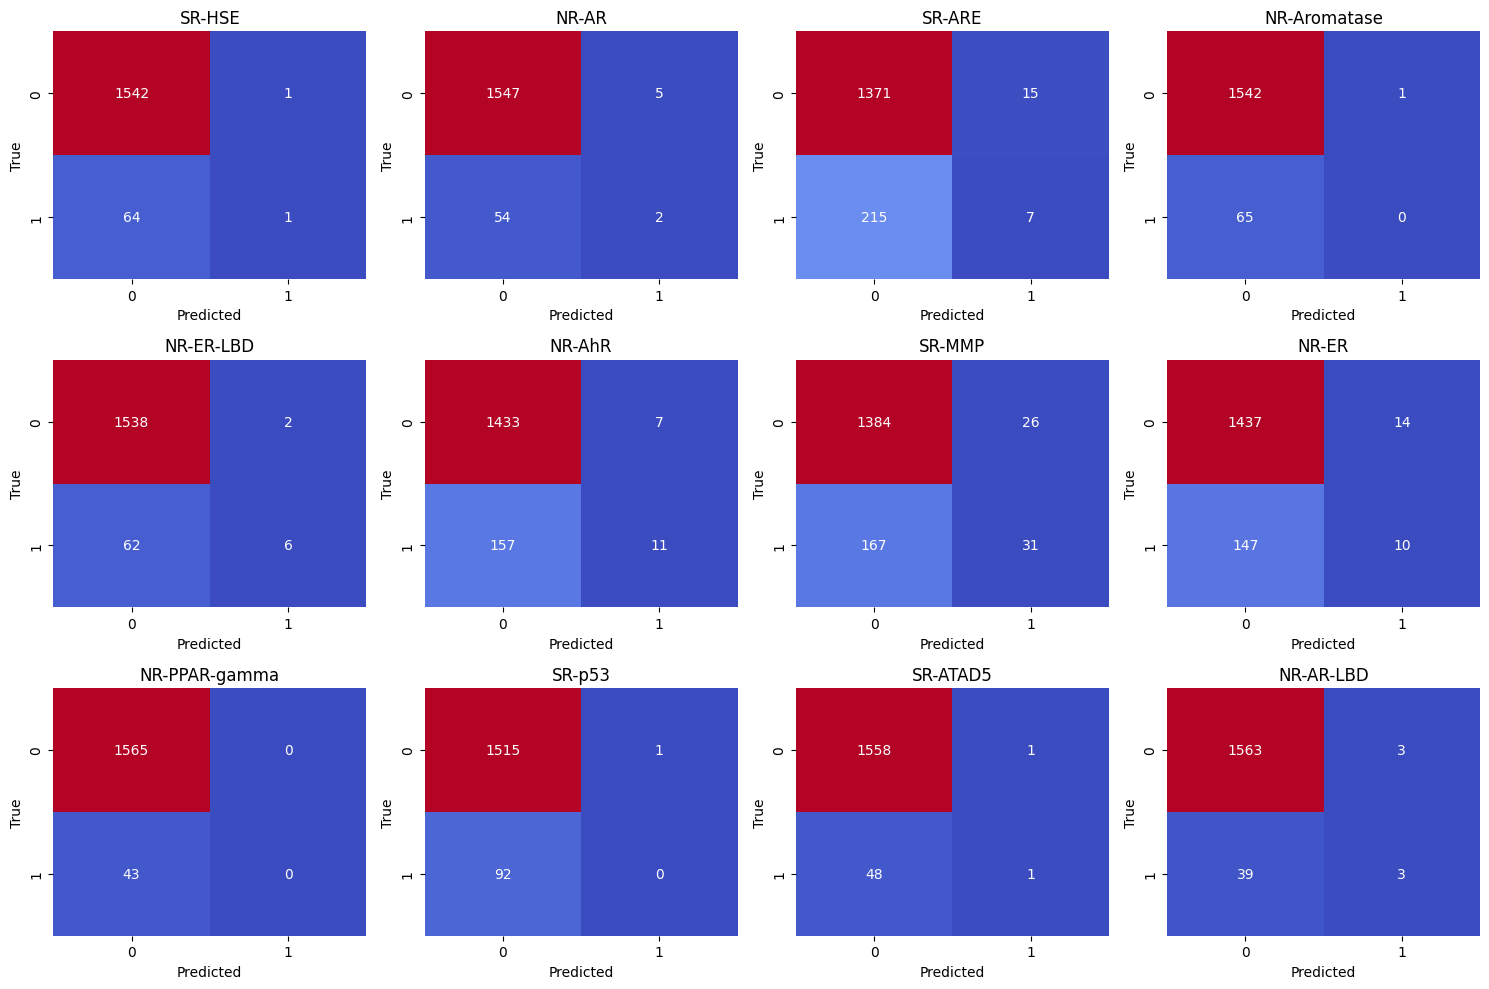

In [42]:
from sklearn.metrics import multilabel_confusion_matrix

mat = multilabel_confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, (ax, label) in enumerate(zip(axes, label_columns)):
    sns.heatmap(mat[i], annot=True, fmt='d', ax=ax, cmap='coolwarm', cbar=False)
    ax.set_title(label)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()
